# QUANTUM BOLTZMANN MACHINE

Quantum Boltzmann Machine (QBM) is a machine learning approach based on quantum Boltzmann distribution and exploiting the rapid growth of the Hilbert space dimension to speed up the classical machine learning algorithm: the Boltzman Machine (BM), when implemented on a quantum hardware. 

In this small research project we try to replicate the results of the paper 'Quantum Boltzmann Machine' by Mohammad H. Amin et al. : https://arxiv.org/abs/1601.02036. In particular, we focus on its first example (Section 4) of a fully visible model with N variables (spin or qubit), this allows to confront the training of classical Boltzmann Machine, quantum Boltzmann Machine and another variant called bound-QBM. 

In the models, a state is associated to an energy function or Hamiltonian. The goal is to learn the energy parameters b, w, gamma, so that the learned distribution of the data (Boltzmann distribution) is as similar as possible to the actual data distribution. The learning is achieved by finding the parameters that minimize a negative average log-likelihood function. The minimization is done by adjusting the parameters at each step in the opposite direction of the gradient of the likelihood (gradient descent technique). The step size is controlled by a fixed learning rate eta.

All three algorithms are presented below, along with commentary and a final plot to compare the results obtained.

## Classical Boltzmann Machine

In the fully visible BM model, given N spin variables (binary units) that define a state, there are N + N(N-1)/2 trainable parameters: b(a) and w(a,b); gamma = 0 : there are no transverse components of spin. 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

def energy(z, b, W):
    """ 
    E(z) = - sum_a (b_a z_a) - sum_{a,b} (w_{a,b} z_a z_b)
    for a single configuration z in {+1, -1}^N. 
    """
    # We'll compute this directly:
    #   E(z) = - (b·z + z^T W z)
    bz = np.dot(b, z)
    zWz = np.dot(z, np.matmul(W, z))
    return -(bz + zWz)

def boltzmann_distribution(b, W, all_states):
    """
    Enumerate all states z in {+1, -1}^N, compute
        P_model(z) = exp[-E(z)] / Z
    and return a (2^N,) probability vector.
    """
    energies = []
    for z in all_states:
        E_z = energy(z, b, W)
        energies.append(E_z)
    energies = np.stack(energies)  # shape (2^N)

    # exponentiate -E(z) already appears in 'energies' as negative
    # but we have E_z = -(...) so actually we want exp(-E_z) = exp(+ ...).
    # Let's just do exp(-E_z):
    negE = -energies
    exp_shifted = np.exp(negE)
    Z = exp_shifted.sum()
    return exp_shifted / Z

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def kl_divergence(P_data, P_model):
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

# Define Parameters
N = 7  # Number of visible spins z in {+1, -1}
M = 8  # Number of modes for data distribution
p = 0.9 # Spin alignment probability with mode centers
eta = 0.3  # Learning rate
num_steps = 35 # Number of optimization steps

The learning rate parameter is chosen empirically as the one that enables the algorithm to obtain the lowest value of KL divergence, which quantifies the quality of training. The same approach has been applied to the QBM and bound-QBM models. 

In [78]:
# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N))  # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

# Enumerate all states z in {+1, -1}^N
all_configs = list(itertools.product([-1, +1], repeat=N))
all_z = np.array(all_configs, dtype=np.float32)  # (2^N, N)

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs

P_data = mixture_data_distribution(all_z, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024

Check sum of P_data: 1.0
Check dimension of P_data: (128,)


In the BM fully visible model the gradient steps are expressed as difference of two terms called 'positive' and 'negative' phases. The positive and negative phases for each parameter are obtained by averaging the respective spin variable over the data distribution and the model distribution, respectively.

In [88]:
# Compute 'positive phase' averages once: <z_a>_data, <z_a z_b>_data for each a,b = 1,2,...,N
z_data_avg = np.zeros(N)
zz_data_avg = np.zeros((N, N))
N_states = all_z.shape[0]
for i in range(N_states):
    z_data_avg += P_data[i] * all_z[i, :] 
    zz_data_avg += P_data[i] * np.outer(all_z[i, :], all_z[i, :])

# Manual Gradient Updates Using exact formulas
# Initialize parameters (b, W) using 'random.seed'
np.random.seed(42)
b = 0.01 * np.random.randn(N)
W = 0.01 * np.random.randn(N, N)

kl_history = []
for step in range(num_steps):
    # 1) Compute model distribution
    P_model = boltzmann_distribution(b, W, all_z)
    # 2) 'Negative phase' averages: <z_a>_model, <z_a z_b>_model for each a,b = 1,2,...,N
    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    for i in range(N_states):
      z_model_avg += P_model[i] * all_z[i, :]
      zz_model_avg += P_model[i] * np.outer(all_z[i, :], all_z[i, :])
    
    # Compute gradient steps as difference between positive and negative phases
    db = eta * (z_data_avg - z_model_avg) 
    dW = eta * (zz_data_avg - zz_model_avg)

    b += db
    W += dW
    
    # Compute and save KL value
    this_kl = kl_divergence(P_data, P_model)
    kl_history.append(this_kl.item())

    if step % 5 == 0:
        print(f"Iter {step}: KL = {this_kl.item():.4f}")

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": list(range(num_steps)), "kl_history": kl_history})
df.to_csv("BM.csv", index=False)
print("Dati salvati in BM.csv")

df = pd.read_csv("BM.csv")

Iter 0: KL = 1.0106
Iter 5: KL = 0.2395
Iter 10: KL = 0.1885
Iter 15: KL = 0.1679
Iter 20: KL = 0.1571
Iter 25: KL = 0.1507
Iter 30: KL = 0.1467
Dati salvati in BM.csv


### Plotting results of BM

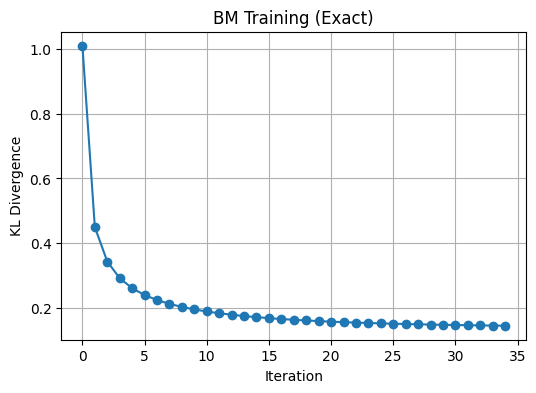

In [89]:
plt.figure(figsize=(6,4))
plt.plot(df['iteration'], df['kl_history'], marker='o', label='KL Divergence')
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")
plt.title("BM Training (Exact)")
plt.grid(True)
plt.show()

## Quantum Boltzmann Machine

In the Quantum Boltzmann Machine, binary spin variables are replaced with (2^N x 2^N) matrices (operators), where N is now the number of quantum bits. The energy function is therefore replaced with a (2^N x 2^N) Hamiltonian matrix. The Hamiltonian is build in such a way that its diagonal elements correspond to classical energy values for each of the 2^N possible classical states. The density matrix is defined as exp(-H), devided by the trace of exp(-H), so that each diagonal element corresponds to the Boltzmann probability of that state. The density matrix is also known as Gibbs state. 

In this fully visible model, each parameter is associated with a (2^N x 2^N) matrix. Gamma is also a parameter to learn, but it is fixed to be the same for each non-diagonal (2^N x 2^N) matrix rapresenting transverse components of spin.

In [109]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Define Parameters
N = 7  # Number of visible qubits
M = 8  # Number of modes for data distribution
p = 0.9  # Spin alignment probability with mode centers
eta = 0.4 # Learning rate (increased)
iterations = 35  # Number of optimization steps

# Pauli Matrices
I = np.array([[1, 0], [0, 1]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])

# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N)) # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs


In [97]:

def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result


We report that while trying to make the code more efficient we tried to compute the function 'tensor_product' using NUMBA. Unfortunately this didn't seem to make the computation faster. 

In [13]:
from numba import njit

@njit
def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

In order to optimize the efficiency of the code we computed the (2^N x 2^N) matrices, representing spin operators, only once out of the 'for loops'. This did make the runtime faster: about 5 times faster than creating spin matrices in each cycle.  

In [98]:
# Compute sigma_z(a), sigma_x(a) and sigma_z(a,b) matrices for each a,b = 1,...,N
gamma_sigma = np.zeros((2**N, 2**N))
b_sigma = np.zeros(N, dtype=object)
W_sigma = np.zeros((N, N),dtype=object)
for a in range(N):
    gamma_sigma += tensor_product([I] * a + [sigma_x] + [I] * (N - a - 1))
    b_sigma[a] = tensor_product([I] * a + [sigma_z] + [I] * (N - a - 1)) 
    for b in range(a + 1, N): 
        W_sigma[a,b] = tensor_product([I] * a + [sigma_z] + [I] * (b - a - 1) + [sigma_z] + [I] * (N - b - 1))

In [99]:
def build_states(N):
    all_states = np.zeros((2**N, N))
    for s in range(N):
        all_states[:, s] = np.diag(b_sigma[s])  # each state is a diagonal element of the sigma_z(a) matrices 
    return all_states

def build_hamiltonian(N, Gamma, b, W):
    """Construct the Fully Visible QBM Hamiltonian with a transverse field."""
    H = np.zeros((2**N, 2**N), dtype=complex) # Size (2^N, 2^N)
    H = -Gamma * gamma_sigma  # Transverse field
    H -= np.dot(b, b_sigma) 
    H -= np.sum(W * W_sigma, axis=None) 
    return H

def compute_density_matrix(H):
    """Compute the density matrix rho = e^(-H)/Z"""
    exp_H = expm(-H)  # exp(-H)
    Z = np.trace(exp_H)
    return exp_H / Z, Z

Again trying to speed up the alogirthm, we computed the exponential of the matrix H approximatevely. Even with a very few order of approsimization (n=2), this did make the code a little faster, but it still didn't allow computation for bigger N. Therefore, we ended up using the numpy function 'expm()' in the final results. 

Note: We tried to use Numba for this function as well.

In [16]:
# Approximation of matrix exponentiation
def matrix_exponential_approx(A, n_terms=2):
    result = np.eye(A.shape[0])
    term = np.eye(A.shape[0]) 
    for i in range(1, n_terms + 1):
        term = np.dot(term, A) / i  
        result += term  
    return result

In [100]:
def compute_full_probability_distribution(rho):
    """Return the diagonal elements of rho as the model probability distribution."""
    return np.real(np.diag(rho))

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def compute_kl_upper_bound(P_data, P_model):
    """Compute the KL divergence upper bound using P_model: diagonal elements of rho."""
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

In the QBM fuly visible model, the gradient steps for each parameter are obtained by summing the expetation value of the derivative of the matrix exp(-H), respect to the parameter, projected on a visible state and averaged over the data distribution of all states, and the expectation value of the respective operator matrix (Boltzmann averaging). 

In [101]:
# Building derivative to compute "positive phase"
def compute_partial_expH(H, rho, Z, projector, partial_H, n):
   avg_v = 0.0
   delta_t = 1.0 / n
   trace = np.trace(projector @ (rho * Z))
   exp_tH = expm(-delta_t * H) # we compute only once exp_th in order to optimize efficiency
   exp1 = np.eye(H.shape[0])
   for m in range(1, n + 1):
      t = m * delta_t
      exp1 = exp1 @ exp_tH  # e^(-τH)
      exp2 = expm((t - 1) * H) # e^{-(1-τ)H}
      avg_v += np.trace(projector @ exp1 @ partial_H @ exp2) / (trace + 1e-12) * delta_t
   return -avg_v

# Compute "positive" and "negative phase" averages: <sigma_z_a>, <sigma_z_a sigma_z_b> for each a,b = 1,2,...,N

state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    n = 2   # To allow computation we kept at minimum the iteration steps of the 'compute_partial_expH' function
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = compute_partial_expH(H, rho, Z, state_proj, gamma_sigma, n)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * compute_partial_expH(H, rho, Z, state_proj, b_sigma[a], n)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * compute_partial_expH(H, rho, Z, state_proj,  W_sigma[a, b], n)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

Our last attempt to speed-up the computation, to be able to compute the machine learning algorithm for larger number of qubits N, was to substitute the function 'compute_partial_expH' with a Fortran function that computed the same derivative. Analizying the code we noticed that this one was, in fact, the computationally most demanding function and removing it would allow the algorithm to run for N=10. Indeed, this function was the main and only difference from the b-QBM algorithm which did run for bigger N (N=10).
We implemented a Fortran test function that only computed a trace of a matrix (H) to verify the speed-up. The test was run with N=10.

#### Fortran test function

subroutine test(A, N, trace)

    integer, intent(in) :: N

    real, dimension(1024, 1024), intent(in) :: A

    real, intent(out) :: trace
    
    integer :: i

    trace=0.
    do i = 1, 2**N
      trace = trace + A(i,i)
    end do
end subroutine test

Note: 'python3 -m numpy.f2py -c -m  test  test.f90' to compile the Fortran f2py module to be able to import it in Python

In [ ]:
import sys
sys.path.append('/filepath')
import test

# N=10
state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = test.test(H, N)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * test.test(H, N)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * test.test(H, N)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

We then computed the same test function using numpy, as before we tested it with N=10.

In [ ]:
def test(H):
    trace_test = np.trace(H)
    return trace_test

# N=10
state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = test(H)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * test(H)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * test(H)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

We found that the runtime was slower with the Fortran function. This led us to abandon the implementation with Fortran.

![Fortran test](Fortran_test_runtime.jpeg)
![Python test](Python_test_runtime.jpeg)

In [110]:
def optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations):
    """Optimize the Fully Visible Bound-Based QBM."""

    kl_divergence = []
    for it in range(iterations):
        H = build_hamiltonian(N, Gamma, b, W)
        rho,_ = compute_density_matrix(H)
        _,Z = compute_density_matrix(H)

        # Compute model distribution
        P_model = compute_full_probability_distribution(rho)

        # Compute and save KL value
        KL_bound = compute_kl_upper_bound(P_data, P_model)
        kl_divergence.append(KL_bound)
        
        delta_b, delta_W, delta_Gamma = compute_gradient_update(P_data, H, rho, Z, all_states, N, eta)
        b += delta_b
        W += delta_W
        Gamma += delta_Gamma

        print(f"Iteration {it+1}/{iterations}, KL Divergence: {KL_bound:.6f}, Δb={np.linalg.norm(delta_b):.6f}, Δw={np.linalg.norm(delta_W):.6f}")
    return kl_divergence

# Initialize parameters (b, W, Gamma) using 'random.seed'
np.random.seed(42)
b = 0.1 * np.random.randn(N)
W = 0.1 * np.random.randn(N, N)
Gamma = 0.1 * np.random.rand()

all_states = build_states(N)
P_data = mixture_data_distribution(all_states, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024
print(type(P_data))

# Optimize the Fully Visible QBM
kl_divergence = optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations)

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": range(1, iterations + 1), "kl_divergence": kl_divergence})
df.to_csv("FullyVisible_QBM.csv", index=False)
print("Dati salvati in FullyVisible_QBM.csv")

df = pd.read_csv("FullyVisible_QBM.csv")

Check sum of P_data: 1.0
Check dimension of P_data: (128,)
<class 'numpy.ndarray'>
Iteration 1/35, KL Divergence: 1.476174, Δb=0.377220, Δw=0.586000
Iteration 2/35, KL Divergence: 0.512288, Δb=0.213406, Δw=0.326509
Iteration 3/35, KL Divergence: 0.236458, Δb=0.126948, Δw=0.135732
Iteration 4/35, KL Divergence: 0.166775, Δb=0.084984, Δw=0.084111
Iteration 5/35, KL Divergence: 0.135862, Δb=0.062548, Δw=0.062221
Iteration 6/35, KL Divergence: 0.118556, Δb=0.050516, Δw=0.047182
Iteration 7/35, KL Divergence: 0.107722, Δb=0.042781, Δw=0.036972
Iteration 8/35, KL Divergence: 0.100357, Δb=0.037174, Δw=0.030112
Iteration 9/35, KL Divergence: 0.095021, Δb=0.032874, Δw=0.025371
Iteration 10/35, KL Divergence: 0.090963, Δb=0.029429, Δw=0.021986
Iteration 11/35, KL Divergence: 0.087766, Δb=0.026598, Δw=0.019451
Iteration 12/35, KL Divergence: 0.085181, Δb=0.024209, Δw=0.017480
Iteration 13/35, KL Divergence: 0.083051, Δb=0.022161, Δw=0.015885
Iteration 14/35, KL Divergence: 0.081269, Δb=0.020377, 

### Plotting results of QBM

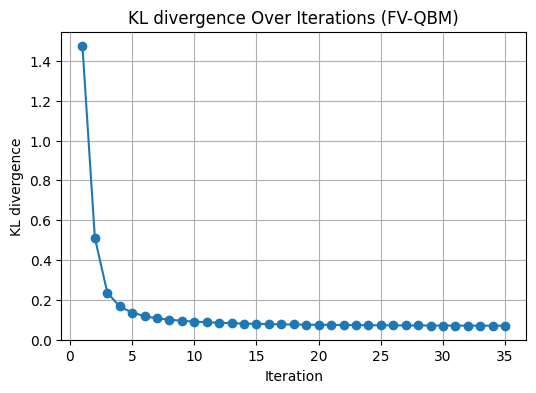

In [112]:
# Plot KL divergence upper bound over iterations
plt.figure(figsize=(6, 4))
plt.plot(df['iteration'], df['kl_divergence'], marker='o', label='KL divergence over Iterations')
plt.xlabel("Iteration")
plt.ylabel("KL divergence")
plt.title("KL divergence Over Iterations (FV-QBM)")
plt.grid()
plt.show()

## bound - Quantum Boltzmann Machine

In the QBM model the minimization of log-likelihood, and therefore the traing of the model, can be inefficient for large systems. For this reason, the likelihood can be substituted with an upper-bound, and it is this upper-bound that is minimized. This approach is called bound-based QBM.

The model is almost identical to the QBM and the gradient steps are still expressed in terms of two different averages, but in this model the first term is simpler due to the introduction of the upper-bound of the likelihood, and can be obtained by sampling from a Boltzmann distribution. 

In this fylly visible model, gamma is kept fixed to a non-zero value (gamma = 2), and therefore is not a trainable parameter.

In [117]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Define Parameters
N = 7  # Number of visible qubits
M = 8  # Number of modes for data distribution
p = 0.9  # Spin alignment probability with mode centers
eta = 0.7 # Learning rate (increased)
iterations = 35  # Number of optimization steps
Gamma = 2 # Fixed transverse field strength

# Pauli Matrices
I = np.array([[1, 0], [0, 1]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])

# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N)) # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs

def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

# Compute sigma_z(a), sigma_x(a) and sigma_z(a,b) matrices for each a,b = 1,...,N
b_sigma = np.zeros(N, dtype=object)
gamma_sigma = np.zeros((2**N, 2**N))
W_sigma = np.zeros((N, N),dtype=object)
for a in range(N):
    gamma_sigma += tensor_product([I] * a + [sigma_x] + [I] * (N - a - 1))
    b_sigma[a] = tensor_product([I] * a + [sigma_z] + [I] * (N - a - 1)) 
    for b in range(a + 1, N): 
        W_sigma[a, b] = tensor_product([I] * a + [sigma_z] + [I] * (b - a - 1) + [sigma_z] + [I] * (N - b - 1))

def build_states(N):
    all_states = np.zeros((2**N, N))
    for s in range(N):
        all_states[:, s] = np.diag(b_sigma[s])  # each state is a diagonal element of the sigma_z(a) matrices 
    return all_states

def build_hamiltonian(N, Gamma, b, W):
    """Construct the Fully Visible QBM Hamiltonian with a transverse field."""
    H = np.zeros((2**N, 2**N), dtype=complex) # Size (2^N, 2^N)
    H = -Gamma * gamma_sigma  # Transverse field
    H -= np.dot(b, b_sigma)  
    H -= np.sum(W * W_sigma, axis=None)  
    return H

def compute_density_matrix(H):
    """Compute the density matrix rho = exp(-H) / Z."""
    exp_H = expm(-H)
    Z = np.trace(exp_H)
    rho = exp_H / Z
    return rho, Z

def compute_full_probability_distribution(rho):
    """Compute the full probability distribution P_v from diagonal elements of rho."""
    return np.real(np.diag(rho))  # Extract diagonal elements as probabilities

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def compute_kl_upper_bound(P_data, P_model):
    """Compute the KL divergence upper bound using P_model: diagonal elements of rho."""
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

As mentioned above, the main and only difference with the QBM model is the computation of the 'gadient_update' function. In this bound-based model the gradient steps are expressend in terms of differences of positive and negative phases, in analogy to the classical Boltzmann Machine. The positive phase for each parameter ends up being the simple average of the relative classical spin variable over the state distribution, while the negative phase is the expactation value of the (2^N x 2^N) operator on the Gibbs state defined by the density matrix. 

In [118]:
# Compute "positive" and "negative phase" averages: <sigma_z_a>, <sigma_z_a sigma_z_b> for each a,b = 1,2,...,N
def compute_gradient_update(P_data, rho, all_states, N, eta):
    """Compute gradient updates for b and w."""

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N))

    # Negative phase
    N_states = all_states.shape[0]
    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @ W_sigma[a, b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]
    
    # Positive phase
    N_states = all_states.shape[0]
    for i in range(N_states):
        z_data_avg += P_data[i] * all_states[i, :]
        zz_data_avg += P_data[i] * np.outer(all_states[i, :], all_states[i, :])

    # Compute gradient steps as difference between positive and negative phases
    delta_b = eta * (z_data_avg - z_model_avg)
    delta_W = eta * (zz_data_avg - zz_model_avg)
    return delta_b, delta_W

def optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations):
    """Optimize the Fully Visible Bound-Based QBM."""

    kl_upper_bounds = []
    for it in range(iterations):
        H = build_hamiltonian(N, Gamma, b, W)
        rho, _ = compute_density_matrix(H)

        # Compute model distribution
        P_model = compute_full_probability_distribution(rho)
        
        # Compute and save KL value
        KL_bound = compute_kl_upper_bound(P_data, P_model)
        kl_upper_bounds.append(KL_bound)
        
        delta_b, delta_W = compute_gradient_update(P_data, rho, all_states, N, eta)
        b += delta_b
        W += delta_W

        print(f"Iteration {it+1}/{iterations}, KL Upper Bound: {KL_bound:.6f}, Δb={np.linalg.norm(delta_b):.6f}, Δw={np.linalg.norm(delta_W):.6f}")
    return kl_upper_bounds

# Initialize parameters (b, W) using 'random.seed'
np.random.seed(42)
b = 0.01 * np.random.randn(N)
W = 0.01 * np.random.randn(N, N)

all_states = build_states(N)
P_data = mixture_data_distribution(all_states, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024
print(type(P_data))

# Optimize the Fully Visible Bound-Based QBM
kl_upper_bounds = optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations)

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": range(1, iterations + 1), "kl_upper_bounds": kl_upper_bounds})
df.to_csv("FullyVisible_bQBM.csv", index=False)
print("Dati salvati in FullyVisible_bQBM.csv")

df = pd.read_csv("FullyVisible_bQBM.csv")

Check sum of P_data: 1.0
Check dimension of P_data: (128,)
<class 'numpy.ndarray'>
Iteration 1/35, KL Upper Bound: 1.017814, Δb=0.524497, Δw=2.141081
Iteration 2/35, KL Upper Bound: 0.643224, Δb=0.349230, Δw=2.082532
Iteration 3/35, KL Upper Bound: 0.444985, Δb=0.250411, Δw=2.037496
Iteration 4/35, KL Upper Bound: 0.355666, Δb=0.198445, Δw=2.018051
Iteration 5/35, KL Upper Bound: 0.311326, Δb=0.163854, Δw=2.012195
Iteration 6/35, KL Upper Bound: 0.283231, Δb=0.139320, Δw=2.009774
Iteration 7/35, KL Upper Bound: 0.262824, Δb=0.122626, Δw=2.008234
Iteration 8/35, KL Upper Bound: 0.246938, Δb=0.111003, Δw=2.007078
Iteration 9/35, KL Upper Bound: 0.234060, Δb=0.102389, Δw=2.006175
Iteration 10/35, KL Upper Bound: 0.223346, Δb=0.095590, Δw=2.005462
Iteration 11/35, KL Upper Bound: 0.214263, Δb=0.089960, Δw=2.004897
Iteration 12/35, KL Upper Bound: 0.206445, Δb=0.085139, Δw=2.004446
Iteration 13/35, KL Upper Bound: 0.199633, Δb=0.080911, Δw=2.004082
Iteration 14/35, KL Upper Bound: 0.193636,

### Plotting results of b-QBM

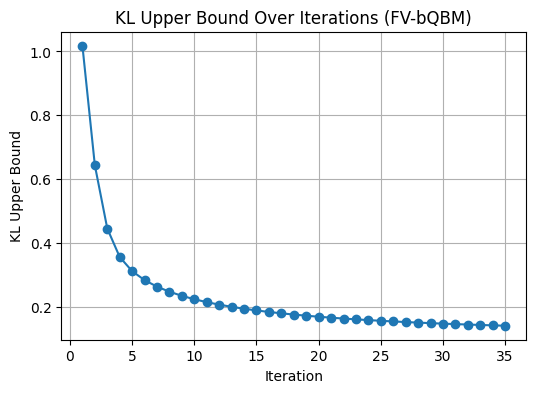

In [119]:
# Plot KL divergence upper bound over iterations
plt.figure(figsize=(6, 4))
plt.plot(df['iteration'], df['kl_upper_bounds'], marker='o', label='KL Upper Bound over Iterations')
plt.xlabel("Iteration")
plt.ylabel("KL Upper Bound")
plt.title("KL Upper Bound Over Iterations (FV-bQBM)")
plt.grid()
plt.show()

### Plotting results of BM, QBM and b-QBM all together for a comparison

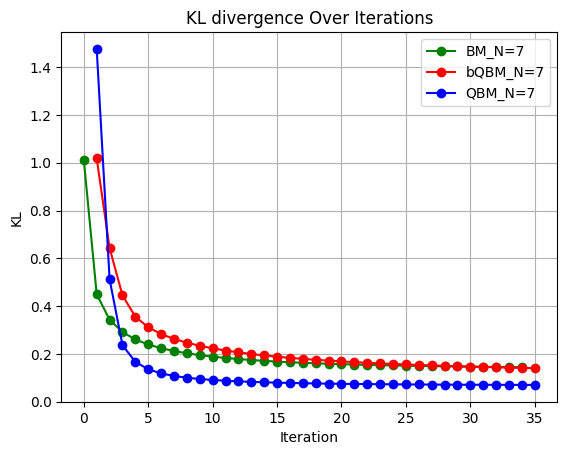

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/andreadecristofaro/BM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_history'], marker='o', color='green', label='BM_N=7')

file_path = "/Users/andreadecristofaro/FullyVisible_bQBM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_upper_bounds'], marker='o', color='red', label='bQBM_N=7')

file_path = "/Users/andreadecristofaro/FullyVisible_QBM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_divergence'], marker='o', color='blue', label='QBM_N=7')

plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("KL divergence Over Iterations")
plt.legend()
plt.grid()
plt.show()
